# Introduction to Debugging

In this book, we want to explore _debugging_ - the art and science of fixing bugs in computer software. In particular, we want to explore techniques that _automatically_ answer questions like: Where is the bug? When does it occur? And how can we repair it? But before we start automating the debugging process, we first need to understand what this process is.

In this chapter, we introduce basic concepts of systematic software debugging and the debugging process, and at the same time get acquainted with Python and interactive notebooks.

**Prerequisites**

* The book is meant to be a standalone reference; however, a number of _great books on debugging_ are listed at the end,
* Knowing a bit of _Python_ is helpful for understanding the code examples in the book.

In [1]:
import bookutils

In [2]:
from bookutils import quiz

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Intro_Debugging import <identifier>
```

and then make use of the following features.


In this chapter, we introduce some basics of how failures come to be as well as a general process for debugging.



## A Simple Function

### Your Task: Remove HTML Markup

Let us start with a simple example. You may have heard of how documents on the Web are made out of text and HTML markup. HTML markup consists of _tags_ in angle brackets that surround the text, providing additional information on how the text should be interpreted. For instance, in the HTML text

```html
This is <em>emphasized</em>.
```

the word "emphasized" is enclosed in the HTML tags `<em>` (start) and `</em>` (end), meaning that it should be interpreted (and rendered) in an emphasized way – typically in italics. In your environment, the HTML text gets rendered as

> This is <em>emphasized</em>.

There's HTML tags for pretty much everything – text markup (<strong>bold</strong> text, <s>strikethrough</s> text), text structure (titles, lists), references (links) to other documents, and many more. These HTML tags shape the Web as we know it.

However, within all the HTML markup, it may become difficult to actually access the _text_ that lies within. We'd like to implement a simple function that removes _HTML markup_ and converts it into text. If our input is

```html
Here's some <strong>strong argument</strong>.
```
the output should be

> Here's some strong argument.

Here's a Python function which does exactly this. It takes a (HTML) string and returns the text without markup.

In [3]:
def remove_html_markup(s):
    tag   = False
    out   = ""

    for c in s:
        if c == '<':   # start of markup
            tag = True
        elif c == '>': # end of markup
            tag = False
        elif not tag:
            out = out + c
    
    return out

This function works, but not always. Before we start debugging things, let us first explore its code and how it works.

### Understanding Python Programs

If you're new to Python, you might first have to understand what the above code does.  We very much recommend the [Python tutorial](https://docs.python.org/3/tutorial/) to get an idea on how Python works.  The most important things for you to understand the above code are these three:

1. Python structures programs through _indentation_, so the function and `for` bodies are defined by being indented;
2. Python is _dynamically typed_, meaning that the type of variables like `x`, `approx`, or `guess` is determined at run-time.
3. Most of Python's syntactic features are inspired by other common languages, such as control structures (`while`, `if`, `for`), assignments (`=`), or comparisons (`==`, `!=`, `<`).

With that, you can already understand what the above code does: `remove_html_markup()` takes a (HTML) string `s` and then iterates over the individual characters (`for c in s`). By default, these characters are added to the return string `out`. However, if `remove_html_markup()` finds a `<` character, it sets the `tag` flag, meaning that all further characters are ignored until a `>` character is found.

In contrast to other languages, Python makes no difference between strings and characters – there's only strings. As in HTML, strings can be enclosed in single quotes (`'a'`) and in double quotes (`"a"`). This is useful if you want to specify a string that contains quotes, as in `'She said "hello", and then left'` or `"The first character is a 'c'"`

### Running a Function

To find out whether `remove_html_markup()` works correctly, we can *test* it with a few values.  For the string

```html
Here's some <strong>strong argument</strong>.
```

for instance, it produces the correct value:

In [4]:
remove_html_markup("Here's some <strong>strong argument</strong>.")

"Here's some strong argument."

### Interacting with Notebooks

If you are reading this in the interactive notebook, you can try out `remove_html_markup()` with other values as well.  Click on the above cells with the invocation of `remove_html_markup()` and change the value – say, to `remove_html_markup("<em>foo</em>")`.  Press `Shift+Enter` (or click on the play symbol) to execute it and see the result.  If you get an error message, go to the above cell with the definition of `remobve_html_markup()` and execute this first.  You can also run _all_ cells at once; see the Notebook menu for details.  (You can actually also change the text by clicking on it, and corect mistaks such as in this sentence.)

Executing a single cell does not execute other cells, so if your cell builds on a definition in another cell that you have not executed yet, you will get an error.  You can select `Run all cells above` from the menu to ensure all definitions are set.

Also keep in mind that, unless overwritten, all definitions are kept across executions.  Occasionally, it thus helps to _restart the kernel_ (i.e. start the Python interpreter from scratch) to get rid of older, superfluous definitions.

### Testing a Function

Since one can change not only invocations, but also definitions, we want to ensure that our function works properly now and in the future. To this end, we introduce tests through _assertions_ – a statement that fails if the given _check_ is false. The following assertion, for instance, checks that the above call to `remove_html_markup()` returns the correct value:

In [5]:
assert remove_html_markup("Here's some <strong>strong argument</strong>.") == "Here's some strong argument."

If you change the code of `remove_html_markup()` such that the above assertion fails, you will have introduced a bug.

## Oops! A Bug!

As nice and simple as `remove_html_markup()` is, it is buggy. Some HTML markup is not properly stripped away. Consider this HTML tag, which would render as an input field in a form:

```html
<input type="text" value="<your name>">
```
If we feed this string into `remove_html_markup()`, we would expect an empty string as the result. Instead, this is what we get:

In [6]:
remove_html_markup('<input type="text" value="<your name>">')

'"'

Every time we encounter a bug, this means that our earlier tests have failed. We thus need to introduce another test that documents not only how the bug came to be, but also the result we actually expected.

The assertion we write now fails with an error message. (The `ExpectError` magic ensures we see the error message, but the rest of the notebook is still executed.)

In [7]:
from ExpectError import ExpectError

In [8]:
with ExpectError():
    assert remove_html_markup('<input type="text" value="<your name>">') == ""

Traceback (most recent call last):
  File "<ipython-input-8-c7b482ebf524>", line 2, in <module>
    assert remove_html_markup('<input type="text" value="<your name>">') == ""
AssertionError (expected)


With this, we now have our task: _Fix the failure as above._

## Visualizing Code

To properly understand what is going on here, it helps drawing a diagram on how `remove_html_markup()` works. Technically, `remove_html_markup()` implements a _state machine_ with two states `tag` and `¬ tag`. We change between these states depending on the characters we process. This is visualized in the following diagram:

In [9]:
from graphviz import Digraph, nohtml

In [10]:
from IPython.display import display

In [11]:
PASS = "✔"
FAIL = "✘"

PASS_COLOR = 'darkgreen'  # '#006400' # darkgreen
FAIL_COLOR = 'red4'  # '#8B0000' # darkred

STEP_COLOR = 'peachpuff'
FONT_NAME = 'Raleway'

In [12]:
def graph(comment="default"):
    return Digraph(comment=comment, graph_attr={'rankdir': 'LR'}, 
        node_attr={'style': 'filled', 'fillcolor': STEP_COLOR, 'fontname': FONT_NAME},
        edge_attr={'fontname': FONT_NAME})

In [13]:
state_machine = graph()
state_machine.node('Start', )
state_machine.edge('Start', '¬ tag')
state_machine.edge('¬ tag', '¬ tag', label=" ¬ '<'\nadd character")
state_machine.edge('¬ tag', 'tag', label="'<'")
state_machine.edge('tag', '¬ tag', label="'>'")
state_machine.edge('tag', 'tag', label="¬ '>'")

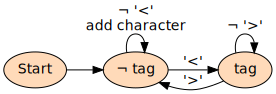

In [14]:
# ignore
display(state_machine)

You see that we start in the non-tag state (`¬ tag`). Here, for every character that is not `'<'`, we add the character and stay in the same state. When we read a `'<'`, though, we end in the tag state (`tag`) and stay in that state (skipping characters) until we find a closing `'>'` character.

## A First Fix

Let us now look at the above state machine, and process through our input:

```html
<input type="text" value="<your name>">
```

So what you can see is: We are interpreting the `'>'` of `"<your name>"` as the closing of the tag. However, this is a quoted string, so the `'>'` should be interpreted as a regular character, not as markup. This is an example of _missing functionality:_ We do not handle quoted characters correctly. We haven't claimed yet to take care of all functionality, so we still need to extend our code.

So we extend the whole thing.  We set up a special "quote" state which processes quoted inputs in tags until the end of the quoted string is reached. This is how the state machine looks like:

In [15]:
state_machine = graph()
state_machine.node('Start')
state_machine.edge('Start', '¬ quote\n¬ tag')
state_machine.edge('¬ quote\n¬ tag', '¬ quote\n¬ tag', label="¬ '<'\nadd character")
state_machine.edge('¬ quote\n¬ tag', '¬ quote\ntag', label="'<'")
state_machine.edge('¬ quote\ntag', 'quote\ntag', label="'\"'")
state_machine.edge('¬ quote\ntag', '¬ quote\ntag', label="¬ '\"' ∧ ¬ '>'")
state_machine.edge('quote\ntag', 'quote\ntag', label="¬ '\"'")
state_machine.edge('quote\ntag', '¬ quote\ntag', label="'\"'")
state_machine.edge('¬ quote\ntag', '¬ quote\n¬ tag', label="'>'")

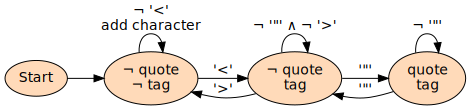

In [16]:
display(state_machine)

This is a bit more complex already. Proceeding from left to right, we first have the state `¬ quote ∧ ¬ tag`, which is our "standard" state for text. If we encounter a `'<'`, we again switch to the "tagged" state `¬ quote ∧ tag`. In this state, however (and only in this state), if we encounter a quotation mark, we switch to the "quotation" state `quote ∧ tag`, in which we remain until we see another quotation mark indicating the end of the string – and then continue in the "tagged" state `¬ quote ∧ tag` until we see the end of the string.

Things get even more complicated as HTML allows both single and double quotation characters. Here's a revised implementation of `remove_html_markup()` that takes the above states into account:

In [17]:
def remove_html_markup(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

Now, our previous input works well:

In [18]:
remove_html_markup('<input type="text" value="<your name>">')

''

and our earlier tests also pass:

In [19]:
assert remove_html_markup("Here's some <strong>strong argument</strong>.") == "Here's some strong argument."

In [20]:
assert remove_html_markup('<input type="text" value="<your name>">') == ""

However, the above code still has a bug.  In two of these inputs, HTML markup is still not properly stripped:

```html
<b>foo</b>
<b>"foo"</b>
"<b>foo</b>"
<"b">foo</"b">
```

Can you guess which ones these are?

Again, a simple assertion will reveal the culprits:

In [21]:
with ExpectError():
    assert remove_html_markup('<b>foo</b>') == 'foo'

In [22]:
with ExpectError():
    assert remove_html_markup('<b>"foo"</b>') == '"foo"'

Traceback (most recent call last):
  File "<ipython-input-22-ebb80f5cdc78>", line 2, in <module>
    assert remove_html_markup('<b>"foo"</b>') == '"foo"'
AssertionError (expected)


In [23]:
with ExpectError():
    assert remove_html_markup('"<b>foo</b>"') == '"foo"'

Traceback (most recent call last):
  File "<ipython-input-23-1f9c40f6f95d>", line 2, in <module>
    assert remove_html_markup('"<b>foo</b>"') == '"foo"'
AssertionError (expected)


In [24]:
with ExpectError():
    assert remove_html_markup('<"b">foo</"b">') == 'foo'    

So, unfortunately, we're not done yet – our function still has errors.

## The Devil's Guide to Debugging

Let us now discuss a couple of methods that do _not_ work well for debugging. (These "devil's suggestions" are adapted from the 1993 book "Code Complete" from Steve McConnell.)

### Printf Debugging

When I was a student,  never got any formal training in debugging, so I had to figure this out for myself. What I learned was how to use _debugging output_; in Python, this would be the `print()` function. For instance, I would go and scatter `print()` calls everywhere:

In [25]:
def remove_html_markup_with_print(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        print("c =", repr(c), "tag =", tag, "quote =", quote)

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

This way of inspecting executions is commonly called "Printf debugging", after the C `printf()` function. Then, running this would allow me to see what's going on in my code:

In [26]:
remove_html_markup_with_print('<b>"foo"</b>')

c = '<' tag = False quote = False
c = 'b' tag = True quote = False
c = '>' tag = True quote = False
c = '"' tag = False quote = False
c = 'f' tag = False quote = True
c = 'o' tag = False quote = True
c = 'o' tag = False quote = True
c = '"' tag = False quote = True
c = '<' tag = False quote = False
c = '/' tag = True quote = False
c = 'b' tag = True quote = False
c = '>' tag = True quote = False


'foo'

Yes, one sees what is going on – but this is horribly inefficient!  Think of a 1,000-character input – you'd have to go through 2,000 lines of logs.  It may help you, but it's a total time waster.  Plus, you have to enter these statements, remove them again... it's a maintenance nightmare.

(You may even forget printf's in your code, creating a security problem: Mac OS X versions 10.7 to 10.7.3 would log the password in clear because someone had forgotten to turn off debugging output.)

### Debugging into Existence

I would also try to _debug the program into existence._  Just change things until they work.  Let me see: If I remove the conditions "and not quote" from the program, it would actually work again:

In [27]:
def remove_html_markup_without_quotes(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        if c == '<': # and not quote:
            tag = True
        elif c == '>': # and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

In [28]:
assert remove_html_markup_without_quotes('<"b">foo</"b">') == 'foo'    

Cool! Unfortunately, the function still fails on the other input:

In [29]:
with ExpectError():
    assert remove_html_markup_without_quotes('<b>"foo"</b>') == '"foo"'

Traceback (most recent call last):
  File "<ipython-input-29-1d8954a52bcf>", line 2, in <module>
    assert remove_html_markup_without_quotes('<b>"foo"</b>') == '"foo"'
AssertionError (expected)


So, maybe we can change things again, such that both work? And maybe the other tests we had earlier won't fail? Let's just continue to change things randomly again and again and again.

Oh, and of course, I would never back up earlier versions such that I would be able to keep track of what has changed and when.

### Use the Most Obvious Fix

My favorite: Use the most obvious fix.  This means that you're fixing the symptom, not the problem. In our case, this would be something like:

In [30]:
def remove_html_markup_fixed(s):
    if s == '<b>"foo"</b>':
        return '"foo"'
    
    ...

Miracle! Our earlier failing assertion now works! Now we can do the same for the other failing test, too, and we're done.
(Rumor has it that some programmers use this technique to get their tests to pass...)

### Things to do Instead

As with any devil's guide, you get an idea of how to do things by doing the _opposite._  What this means is:

1. Understand the code
2. Fix the problem, not the symptom
3. Proceed systematically

which is what we will apply for the rest of this chapter.

## From Defect to Failure

To understand how to systematically debug a program, we first have to understand how failures come to be. The typical debugging situation looks like this. We have a program (execution), taking some input and producing some output. The output is in *error* (✘), meaning an unwanted and unintended deviation from what is correct, right, or true.
The input, in contrast, is assumed to be correct (✔). (Otherwise, we wouldn't search for the bug in our program, but in whatever produced its input.)

In [31]:
def execution_diagram(show_steps=True, variables=[], steps=3, error_step=666, until=666, fault_path=[]):
    dot = graph()

    dot.node('input', shape='none', fillcolor='white', label=f"Input {PASS}", fontcolor=PASS_COLOR)
    last_outgoing_states = ['input']
    
    for step in range(1, min(steps + 1, until)):
        
        if step == error_step:
            step_label=f'Step {step} {FAIL}'
            step_color=FAIL_COLOR
        else:
            step_label=f'Step {step}'
            step_color=None

        if step >= error_step:
            state_label=f'State {step} {FAIL}'
            state_color=FAIL_COLOR
        else:
            state_label=f'State {step} {PASS}'
            state_color=PASS_COLOR
    
        state_name = f's{step}'
        outgoing_states = []
        incoming_states = []

        if not variables:
            dot.node(name=state_name, label=state_label, shape='box', color=state_color, fontcolor=state_color)
        else:
            var_labels = []
            for v in variables:
                vpath = f's{step}:{v}'
                if vpath in fault_path:
                    var_label = f'<{v}>{v} ✘'
                    outgoing_states.append(vpath)
                    incoming_states.append(vpath)
                else:
                    var_label = f'<{v}>{v}'
                var_labels.append(var_label)
            record_string = " | ".join(var_labels)
            dot.node(name=state_name, shape='record', label=nohtml(record_string), color=state_color, fontcolor=state_color)
            
        if not outgoing_states:
            outgoing_states = [state_name]
        if not incoming_states:
            incoming_states = [state_name]

        for outgoing_state in last_outgoing_states:
            for incoming_state in incoming_states:
                if show_steps:
                    dot.edge(outgoing_state, incoming_state, label=step_label, fontcolor=step_color)
                else:
                    dot.edge(outgoing_state, incoming_state)

        last_outgoing_states = outgoing_states

    if until > steps + 1:
        # Show output
        if error_step > steps:
            dot.node('output', shape='none', fillcolor='white', label=f"Output {PASS}", fontcolor=PASS_COLOR)
        else:
            dot.node('output', shape='none', fillcolor='white', label=f"Output {FAIL}", fontcolor=FAIL_COLOR)

        for outgoing_state in last_outgoing_states:
            label = "Execution" if steps == 0 else None
            dot.edge(outgoing_state, 'output', label=label)

    display(dot)

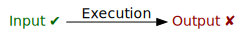

In [32]:
# ignore
execution_diagram(show_steps=False, steps=0, error_step=0)

This situation we see above is what we call a *failure*: An externally visible _error_ in the program behavior, with the error again being an unwanted and unintended deviation from what is correct, right, or true.

How does this failure come to be? The execution we see above breaks down into several program _states_, one after the other.

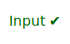

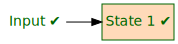

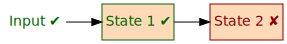

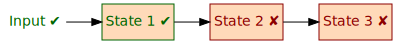

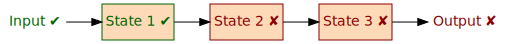

In [33]:
# ignore
for until in range(1, 6):
    execution_diagram(show_steps=False, until=until, error_step=2)

Initially, the program state is still correct (✔). However, at some point in the execution, the state gets an _error_, also known as a *fault*. This fault – again an unwanted and unintended deviation from what is correct, right, or true – then propagates along the execution, until it becomes externally visible as a _failure_.
(In reality, there are many, many more states than just this, but these would not fit in a diagram.)

How does a fault come to be? Each of these program states is produced by a _step_ in the program code. These steps take a state as input and produce another state as output. Technically speaking, the program inputs and outputs are also parts of the program state, so the input flows into the first step, and the output is the state produced by the last step.

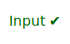

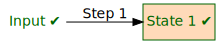

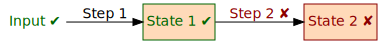

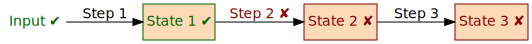

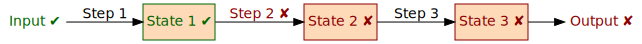

In [34]:
# ignore
for until in range(1, 6):
    execution_diagram(show_steps=True, until=until, error_step=2)

Now, in the diagram above, Step 2 gets a _correct_ state as input and produces a _faulty_ state as output. The produced fault then propagates across more steps to finally become visible as a _failure_.

The goal of debugging thus is to _search_ for the step in which the state first becomes faulty. The _code_ associated with this step is again in error – an unwanted and unintended deviation from what is correct, right, or true – and is called a _defect_. This is what we have to find – and to fix.

Sounds easy, right? Unfortunately, things are not that easy, and that has something to do with the program state. Let us assume our state consists of three variables, `v1` to `v3`, and that Step 2 produces a fault in `v2`. This fault then propagates to the output:

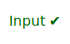

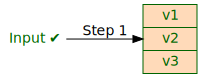

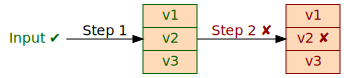

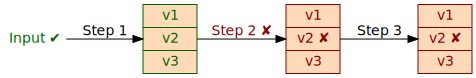

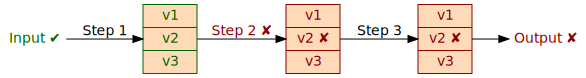

In [35]:
# ignore
for until in range(1, 6):
    execution_diagram(show_steps=True, variables=['v1', 'v2', 'v3'], error_step=2, 
                      until=until, fault_path=['s2:v2', 's3:v2'])

The way these faults propagate is called a *cause-effect chain*:

* The _defect_ in the code _causes_ a fault in the state when executed.
* This _fault_ in the state then _propagates_ through further execution steps...
* ... until it becomes visible as a _failure_.

Since the code was originally written by a human, any defect can be related to some original _mistake_ the programmer made. This gives us a number of terms that all are more precise than the general "error" or the colloquial "bug":

* A _mistake_ is a human act or decision resulting in an error.
* A _defect_ is an error in the program code. Also called *bug*.
* A _fault_ is an error in the program state. Also called *infection*.
* A _failure_ is an externally visible error in the program behavior. Also called *malfunction*.

The cause-effect chain of events is thus

* Mistake → Defect → Fault → ... → Fault → Failure

Note that not every defect also causes a failure, which is despite all testing, there can still be defects in the code looming around until the right conditions are met to trigger them. On the other hand, though, _every failure can be traced back to the defect that causes it_. Our job is to break the cause-effect chain.

## From Failure to Defect

To find a defect from a failure, we _trace back_ the faults along their _propagation_ – that is, we find out which faults in the earlier state have caused the later faults. We start from the very end of the execution and then gradually progress backwards in time, examining fault after fault until we find a _transition_ from a correct state to a faulty state – that is, a
step in which a correct state comes in and a faulty state comes out. At this point, we have found the origin of the failure – and the defect that causes it.

What sounds like a straight-forward strategy, unfortunately, doesn't always work this way in practice. That is because of the following problems of debugging:

* First, program states are actually _large_, encompassing dozens to thousands of variables, possibly even more. If you have to search all of these manually and check them for faults, you will spend a lot of time for a single state.

* Second, you do not always know _whether a state is correct or not._ While most programs have some form of specification for their inputs and outputs, these do not necessarily exist for intermediate results. If one had a specification that could check each state for correctness (possibly even automatically), debugging would be trivial. Unfortunately, it is not, and that's partly due to the lack of specifications.

* Third, executions typically do not come in a handful of steps, as in the diagrams above; instead, they can easily encompass _thousands to millions of steps._ This means that you will have to examine not just one state, but several, making the problem much worse.

To make your search efficient, you thus have to _focus_ your search – starting with most likely causes and gradually progressing to the less probable causes. This is what we call a _debugging strategy_.

## The Scientific Method

Now that we know how failures come to be, let's look into how to systematically find their causes. What we need is a _strategy_ that helps us search for how and when the failure comes to be. For this, we use a process called the *scientific method*.

When we are debugging a program, we are trying to find the causes of a given effect – very much like natural scientists try to understand why things in nature are as they are and how they come to be. Over thousands of years, scientists have conducted _observations_ and _experiments_ to come to an understanding of how our world works. The process by which experimental scientists operate has been coined "The scientific method". This is how it works:

1. Formulate a _question_, as in "Why does this apple fall down?".
2. Invent a _hypothesis_ based on knowledge obtained while formulating the question, that may explain the observed behavior. 
3. Determining the logical consequences of the hypothesis, formulate a _prediction_ that can _support_ or _refute_ the hypothesis. Ideally, the prediction would distinguish the hypothesis from likely alternatives.
4. _Test_ the prediction (and thus the hypothesis) in an _experiment_. If the prediction holds, confidence in the hypothesis increases; otherwise, it decreases.
5. Repeat Steps 2–4 until there are no discrepancies between hypothesis and predictions and/or observations.

At this point, your hypothesis may be named a *theory* – that is, a predictive and comprehensive description of some aspect of the natural world. The gravitational theory, for instance, predicts very well how the moon revolves around the earth, and how the earth revolves around the sun.  Our debugging problems are of a slightly lesser scale – we'd like a theory of how our failure came to be – but the process is pretty much the same.

In [36]:
dot = graph()

dot.node('Hypothesis')
dot.node('Observation')
dot.node('Prediction')
dot.node('Experiment')

dot.edge('Hypothesis', 'Observation', label="<Hypothesis<BR/>is <I>supported:</I><BR/>Refine it>", dir='back')
dot.edge('Hypothesis', 'Prediction')

dot.node('Problem Report', shape='none', fillcolor='white')
dot.edge('Problem Report', 'Hypothesis')

dot.node('Code', shape='none', fillcolor='white')
dot.edge('Code', 'Hypothesis')

dot.node('Runs', shape='none', fillcolor='white')
dot.edge('Runs', 'Hypothesis')

dot.node('More Runs', shape='none', fillcolor='white')
dot.edge('More Runs', 'Hypothesis')

dot.edge('Prediction', 'Experiment')
dot.edge('Experiment', 'Observation')
dot.edge('Observation', 'Hypothesis', label="<Hypothesis<BR/>is <I>rejected:</I><BR/>Seek alternative>")

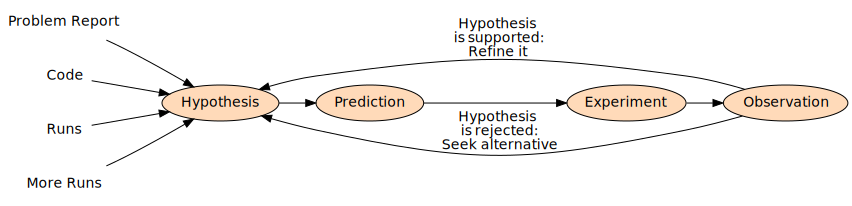

In [37]:
display(dot)

In debugging, we proceed the very same way – indeed, we are treating bugs as if they were natural phenomena.   This analogy may sound far-fetched, as programs are anything but natural.  Nature, by definition, is not under our control.  But bugs are out of our contrl, either, and this is where the analogy works.  This means that we can apply the same techniques.

### Finding a Hypothesis

Let us apply the scientific method to our Python program which removes HTML tags.  First of all, let us recall the problem – `remove_html_markup()` works for some inputs, but fails on others.

In [38]:
for i, html in enumerate([ '<b>foo</b>', '<b>"foo"</b>', '"<b>foo</b>"', '<"b">foo</"b">']):
    result = remove_html_markup(html)
    print("%-2d %-15s %s" % (i + 1, html, result))

1  <b>foo</b>      foo
2  <b>"foo"</b>    foo
3  "<b>foo</b>"    <b>foo</b>
4  <"b">foo</"b">  foo


Input #1 and #4 work as expected, the others do not. We can write these down in a table, such that we can always look back at our previous results:

|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|`<b>foo</b>`|`foo`|`foo`|✔|
|`<b>"foo"</b>`|`"foo"`|`foo`|✘|
|`"<b>foo</b>"`|`"foo"`|`<b>foo</b>`|✘|
|`<"b">foo</"b">`|`foo`|`foo`|✔|


In [39]:
quiz("From the difference between success and failure, we can already devise some observations about what's wrong with the output.  Which of these can we turn into general hypotheses?",
    ["Double quotes are stripped from the tagged input.", 
     "Tags in double quotes are not stripped.",
     "The tag '&lt;b&gt;' is always stripped from the input.",
     "Four-letter words are stripped."], [298 % 33, 1234 % 616])

### Testing a Hypothesis

The hypotheses that remain are:

1. Double quotes are stripped from the tagged input.
2. Tags in double quotes are not stripped.

These may be two separate issues, but chances are they are tied to each other.  Let's focus on 1., because it is simpler.  Does it hold for all inputs, even untagged ones?  Our hypothesis becomes

1. Double quotes are stripped from the ~~tagged~~ input.

Let's devise an experiment to validate this.  If we feed the string
```html
"foo"
```
(including the double quotes) into `remove_html_markup()`, we should obtain
```html
"foo"
```
as result – that is, the output should be the unchanged input. However, if our hypothesis 1. is correct, we should obtain
```html
foo
```
as result – that is, "Double quotes are stripped from the input" as predicted by the hypothesis.

We can very easily test this hypothesis:

In [40]:
remove_html_markup('"foo"')

'foo'

Our hypothesis is confirmed! We can add this to our list of observations.

|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|`<b>foo</b>`|`foo`|`foo`|✔|
|`<b>"foo"</b>`|`"foo"`|`foo`|✘|
|`"<b>foo</b>"`|`"foo"`|`<b>foo</b>`|✘|
|`<"b">foo</"b">`|`foo`|`foo`|✔|
|`"foo"`|`"foo"`|`foo`|✘|


You can try out the hypothesis with more inputs – and it remains valid. Any non-markup input that contains double quotes will have these stripped.

Where does that quote-stripping come from?  This is where we need to explore the cause-effect chain.  The only place in `remove_html_markup()` where quotes are handled is this line:

```python
        elif c == '"' or c == "'" and tag:
             quote = not quote
```

So, quotes should be removed only if `tag` is set. However, `tag` can be set only if the input contains a markup tag, which is not the case for a simple input like `"foo"`. Hence, what we observe is actually _impossible._ Yet, it happens.

### Refining a Hypothesis

Debugging is a game of falsifying assumptions. You assume the code works – it doesn't. You assume the `tag` flag cannot be set – yet it may be. What do we do? Again, we create a hypothesis:

1. The error is due to `tag` being set.

How do we know whether tag is being set?  Let me introduce one of the most powerful debugging tools ever invented, the `assert` statement.  The statement
```python
assert cond
```
evaluates the given condition `cond` and

* if it holds: proceed as usual
* if `cond` does not hold: throw an exception

An `assert` statement _encodes our assumptions_ and as such, should never fail. If it does, well, then something is wrong.

Using `assert`, we can check the value of `tag` all through the loop:

In [41]:
def remove_html_markup_with_tag_assert(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        assert not tag  # <=== Just added

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

Our expectation is that this assertion would fail. So, do we actually get an exception? Try it out for yourself by uncommenting the following line:

In [42]:
# remove_html_markup_with_tag_assert('"foo"')

In [43]:
quiz("What happens after inserting the above assertion?",
    ["The program raises an exception. (i.e., tag is set)",
     "The output is as before, i.e., foo without quotes. (which means that tag is not set)"],
     2)

Here's the solution:

In [44]:
with ExpectError():
    result = remove_html_markup_with_tag_assert('"foo"')
result

'foo'

### Refuting a Hypothesis

We did not get an exception, hence we reject our hypothesis:

1. ~~The error is due to `tag` being set.~~


Again, let's go back to the only place in our code where quotes are handled:

```python
        elif c == '"' or c == "'" and tag:
             quote = not quote
```

Because of the assertion, we already know that `tag` is always False.  Hence, this condition should never hold either.

But maybe there's something wrong with the condition such that it holds? Here's our hypothesis:

1. The error is due to the quote condition evaluating to true


If the condition evaluates to true, then `quote` should be set.  We could now go and assert that `quote` is false; but we only care about the condition.  So we insert an assertion that assumes that setting the code setting the `quote` flag is never reached:

In [45]:
def remove_html_markup_with_quote_assert(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            assert False  # <=== Just added
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

Our expectation this time again is that the assertion fails. So, do we get an exception this time? Try it out for yourself by uncommenting the following line:

In [46]:
# remove_html_markup_with_quote_assert('"foo"')

In [47]:
quiz("What happens after inserting the 'assert' tag?",
["The program raises an exception (i.e., the quote condition holds)",
 "The output is still foo (i.e., the quote condition does not hold)"], 29 % 7)

Here's what happens now that we have the `assert` tag:

In [48]:
with ExpectError():
    result = remove_html_markup_with_quote_assert('"foo"')

Traceback (most recent call last):
  File "<ipython-input-48-9ce255289291>", line 2, in <module>
    result = remove_html_markup_with_quote_assert('"foo"')
  File "<ipython-input-45-7c03457dde82>", line 12, in remove_html_markup_with_quote_assert
    assert False  # <=== Just added
AssertionError (expected)


From this observation, we can deduce that our hypothesis is _confirmed_:

1. The error is due to the quote condition evaluating to true (CONFIRMED)

and the _condition is actually faulty._ It evaluates to True although `tag` is always False:
```python
        elif c == '"' or c == "'" and tag:
             quote = not quote
```
But this condition holds for single and double quotes.  Is there a difference?

Let us see whether our observations generalize towards general quotes:

1. ~~Double~~ quotes are stripped from the input.


We can verify these hypotheses with an additional experiment.  We go back to our original implementation (without any asserts), and then check it:

In [49]:
remove_html_markup("'foo'")

"'foo'"

Surprise: Our hypothesis is rejected and we can add another observation to our table:

|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|`'foo'`|`'foo'`|`'foo'`|✔|

So, the condition

* becomes True when a double quote is seen
* becomes False (as it should) with single quotes

At this point, you should have enough material to solve the problem.  How do we have to fix the condition? Here are four alternatives:

```python
c == "" or c == '' and tag        # Choice 1
c == '"' or c == "'" and not tag  # Choice 2
(c == '"' or c == "'") and tag    # Choice 3
...                               # Something else
```

In [50]:
quiz("How should the condition read?", ["Choice 1", "Choice 2", "Choice 3", "Something else"], 399 % 4)

## Fixing the Bug

So, you have spotted the defect: In Python (and most other languages), `and` takes precedence over `or`, which is why the condition is wrong.  It should read:

```python
(c == '"' or c == "'") and tag
```

(Actually, good programmers rarely depend on precedence; it is considered good style to use parentheses lavishly.)

So, our hypothesis now has become

1. The error is due to the quote condition evaluating to true


Is this our final hypothesis?  We can check our earlier examples whether they should now work well:


|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|`<b>foo</b>`|`foo`|`foo`|✔|
|`<b>"foo"</b>`|`"foo"`|`foo`|✘|
|`"<b>foo</b>"`|`"foo"`|`<b>foo</b>`|✘|
|`<"b">foo</"b">`|`foo`|`foo`|✔|
|`"foo"`|`'foo'`|`foo`|✘|
|`'foo'`|`'foo'`|`'foo'`|✔|

In all of these examples, the `quote` flag should now be set outside of tags; hence, everything should work as expected.

In terms of the scientific process, we now have a *theory* – a hypothesis that

* is consistent with all earlier observations
* predicts future observations (in our case: correct behavior)

For debugging, our problems are usually to small for a big word like theory, so we use the word *diagnosis* instead.  You should start to fix your code if and only if you have a diagnosis.

So we actually go and fix the code accordingly:

In [51]:
def remove_html_markup(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif (c == '"' or c == "'") and tag:  # <-- FIX
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

We verify that the fix was successful by running our earlier tests. Not only should the previously failing tests now pass, the previously passing tests also should not be affected. Fortunately, all tests now pass:

In [52]:
assert remove_html_markup("Here's some <strong>strong argument</strong>.") == "Here's some strong argument."
assert remove_html_markup('<input type="text" value="<your name>">') == ""
assert remove_html_markup('<b>foo</b>') == 'foo'
assert remove_html_markup('<b>"foo"</b>') == '"foo"'
assert remove_html_markup('"<b>foo</b>"') == '"foo"'
assert remove_html_markup('<"b">foo</"b">') == 'foo'    

So, the hypothesis was a theory after all, and our diagnosis was correct.

## Alternate Paths

Note that there are many ways by which we can get to the defect.  We could also have started with our other hypothesis

2. Tags in double quotes are not stripped

and by reasoning and experiments, we would have reached the same conclusion that the condition is faulty:

* To strip tags, the `tag` flag must be set (but it is not).
* To set the `tag` flag, the `quote` variable must not be set (but it is).
* The `quote` flag is set under the given condition (which thus must be faulty).


But just fixing is not enough. We also must make sure the error does not occur again. How can we do that? With our assertions, above, we already have a test suite that should catch several errors – but not all.

To be 100% sure, we could add an assertion to `remove_html_markup()` that checks the final result for correctness. Unfortunately, writing such an assertion is just as complex as writing the function itself.

There is one assertion, though, which could be placed in the loop body to catch this kind of errors, and which could remain in the code. Which is it?

In [53]:
quiz("Which assertion would have caught the problem?",
    ["assert quote and not tag", "assert quote or not tag", "assert tag or not quote", "assert tag and not quote"],
    3270 - 3267)

Indeed, the statement

```python
assert tag or not quote
```
is correct. This excludes the situation of ¬`tag` ∧ `quote` – that is, the `tag` flag is not set, but the `quote` flag is. If you remember our state machine from above, this is actually a state that should never exist:

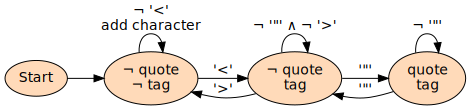

In [54]:
display(state_machine)

Here's our function in its "final" state. As software goes, software is never final – and this may also hold for our function, as there is still room for improvement. For this chapter though, we leave it be.

In [55]:
def remove_html_markup(s):
    tag   = False
    quote = False
    out   = ""

    for c in s:
        assert tag or not quote
        
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif (c == '"' or c == "'") and tag:
            quote = not quote
        elif not tag:
            out = out + c
    
    return out

## Become a Better Debugger

We have now systematically fixed a bug. In this book, we will explore a number of techniques to make debugging easier – coming up with automated diagnoses, explanations, even automatic repairs, including for our example above. But there are also number of things _you_ can do to become a better debugger.


### Follow the Process

If you're an experienced programmer, you may have spotted the problem in `remove_html_markup()` immediately, and start fixing the code right away. But this is dangerous and risky.

Why is this so?  Well, because you should first

* try to understand the problem, and 
* have a full diagnosis before starting to fix away.

You _can_ skip these steps, and jump right to your interactive debugger the very moment you see a failure, happily stepping through their program. This may even work well for simple problems, including this one. The risk, however, is that this narrows your view to just this one execution, which limits your ability to understand _all_ the circumstances of the problem. Even worse: If you start "fixing" the bug without exactly understanding the problem, you may end up with an incomplete solution – as illustrated in "The Devil's Guide to Debugging", above.

### Keep a Log

A second risk of starting debugging too soon is that it lets you easily deviate from a systematic process. Remember how we wrote down every experiment in a table? How we numbered every hypothesis? This is not just for teaching. Writing these things down explicitly allow you to keep track of all your observations and hypotheses over time.

|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|`<b>foo</b>`|`foo`|`foo`|✔|

Every time you come up with a new hypothesis, you can immediately check it against your earlier observations, which will help you eliminating unlikely ones from the start. This is a bit like in the classic "Mastermind" board game, in which you have to guess some secret combination of pins, and in which you opponent gives you hints on whether and how your guesses are correct. At any time, you can see your previous guesses (experiments) and the results (observations) you got; any new guess (hypothesis) as to be consistent with the previous observations and experiments.

![Master Mind Board Grame](https://upload.wikimedia.org/wikipedia/commons/2/2d/Mastermind.jpg)

Keeping such a log also allows you to interrupt your debugging session at any time. You can be home in time, sleep over the problem, and resume the next morning with a refreshed mind. You can even hand over the log to someone else, stating your findings so far.

The alternative to having a long is to _keep all in memory_. This only works for short amounts of time, as puts a higher and higher cognitive load on your memory as you debug along. After some time, you will forget earlier observations, which leads to mistakes. Worst of all, any interruption will break your concentration and make you forget things, so you can't stop debugging until you're done.

Sure, if you are a real master, you can stay glued to the screen all night. But I'd rather be home in time, thank you.

### Rubberducking

A great technique to revisit your observations and to come up with new hypotheses is to _explain the problem to someone else_. In this process, the "someone else" is important, but even more important is that _you are explaining the problem to yourself_! As Kernighan and Pike \cite{kernighan200x} put it:

> Sometimes it takes no more than a few sentences, followed by an embarrassed "Never mind. I see what's wrong. Sorry to bother you."

The reason why this works is that teaching someone else forces you to take different perspectives, and these help you resolving the inconsistency between what you assume and what you actually observe.

Since that "someone else" can be totally passive, you can even replace her with an inanimate object to talk to – even a rubber duck. This technique is called *rubber duck debugging* or *rubberducking* – the idea is that you explain your problem to a rubber duck first before interrupting one of your co-workers with the problem. Some programmers, when asked for advice, explicitly request that you "explain your problem to the duck first", knowing that this resolves a good fraction of problems.

![Rubber duck debugging](https://upload.wikimedia.org/wikipedia/commons/d/d5/Rubber_duck_assisting_with_debugging.jpg)

## The Cost of Debugging

\todo{add recent stuff on how much time debugging takes}

And it's not only that debugging takes time – the worst thing is that it is a search process, which can take anything between a few minutes and several hours, sometimes even days and weeks.  But even if you never know how much time a bug will take, it's a bit of blessing to use a process which gradually gets you towards its cause.

## History of Debugging

Engineers and programmers have long used the term "bug" for faults in their systems – as if it were something that crept into an otherwise flawless program to cause the effects that none could explain. And from a psychological standpoint, it is far easier to blame some "bug" rather than taking responsibility ourselves. In the end, though, we have to face the fact: We made the bugs, and they are ours to fix.

Having said that, there has been one recorded instance where a real bug has crept into a system. That was on September 9, 1947, when a moth got stuck in the relay of a Harvard Mark II machine.  This event was logged, and the log book is now on display at the Smithsonian Natural Museum of American History, as "First actual case of bug being found."

![First actual case of bug being found](https://upload.wikimedia.org/wikipedia/commons/f/ff/First_Computer_Bug%2C_1945.jpg)

The actual term "bug", however, is much older. What do you think is its origin?

In [56]:
import math
import hashlib

bughash = hashlib.md5(b"debug").hexdigest()

In [57]:
quiz('Where has the name "bug" been used to denote disruptive events?',
     ['In the early days of Morse telegraphy, referring to a special key that would send a string of dots',
      'Among radio technicians to describe a device that converts electromagnetic field variations into acoustic signals',
      "In Shakespeare's " '"Henry VI", referring to a walking spectre',
      'In Middle English, where the word "bugge" is the basis for terms like "bugbear" and "bugaboo"'],
    [bughash.index(i) for i in "d42f"])

(Source: \cite{jargon}, \cite{wikipedia:debugging})

## Synopsis

In this chapter, we introduce some basics of how failures come to be as well as a general process for debugging.

## Lessons Learned

1. An _error_ is a deviation from what is correct, right, or true. Specifically,
    * A _mistake_ is a human act or decision resulting in an error.
    * A _defect_ is an error in the program code. Also called *bug*.
    * A _fault_ is an error in the program state. Also called *infection*.
    * A _failure_ is an externally visible error in the program behavior. Also called *malfunction*.
2. In a failing program execution, a mistake by the programmer results in a defect in the code, which creates a fault in the state, which propagates until it results in a failure. Tracing back fault propagation allows to identify the defect that causes the failure.
3. In debugging, the _scientific method_ allows to systematically identify failure causes by gradually refining and refuting hypotheses based on experiments and observations.
4. You can become a better debugger by
    * Following a systematic process like the scientific method
    * Keeping a log of your observations and hypotheses
    * Making your observations and conclusions explicit by telling them somebody (or something).

## Next Steps

In the next chapters, we will learn how to

* [build your own interactive debugger](Debugger.ipynb)
* [locate defects automatically by correlating failures and code coverage](StatisticalDebugger.ipynb)
* [identify and simplify failure-inducing inputs](Reducer.ipynb)

Enjoy!

## Background

\todo{add}

## Exercises

### Exercise 1: More Bugs!

You may have noticed that our `remove_html_markup()` function is still not working perfectly under all circumstances.  The error has something to do with different quotes occurring in the input.

#### Part 1: Find the Problem

What does the problem look like? Set up a test case that demonstrates the problem.

In [58]:
assert(...)

Set up additional test cases as useful.

**Solution.** The remaining problem stems from the fact that in `remove_html_markup()`, we do not differentiate between single and double quotes. Hence, if we have a _quote within a quoted text_, the function may get confused. Notably, a string that begins with a double quote may be interpreted as ending when a single quote is seen, and vice versa. Here's an example of such a string:

```html
<b title="<Shakespeare's play>">foo</b>
```

When we remove the HTML markup, the `>` in the string is interpreted as _unquoted_. Hence, it is interpreted as ending the tag, such that the rest of the tag is not removed.

In [59]:
s = '<b title="<Shakespeare' + "'s play>" + '">foo</b>'
s

'<b title="<Shakespeare\'s play>">foo</b>'

In [60]:
remove_html_markup(s)

'"foo'

In [61]:
with ExpectError():
    assert(remove_html_markup(s) == "foo")

Traceback (most recent call last):
  File "<ipython-input-61-00bc84e50798>", line 2, in <module>
    assert(remove_html_markup(s) == "foo")
AssertionError (expected)


#### Part 2: Identify Extent and Cause

Using the scientific method, identify the extent and cause of the problem. Write down your hypotheses and log your observations, as in

|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|(input)|(expectation)|(output)|(outcome)|


**Solution.** The first step is obviously

|Input|Expectation|Output|Outcome|
|-----|-----------|------|-------|
|<b title="<Shakespeare's play>">foo</b>|foo|"foo|✘|


#### Part 3: Fix the Problem

Design a fix for the problem. Show that it satisfies the earlier tests and does not violate any existing test.

**Solution**. Here's an improved implementation that actually tracks the opening and closing quote by storing the quoting character in the `quote` variable. (If `quote` is `''`, we are not in a string.)

In [62]:
def remove_html_markup_with_proper_quotes(s):
    tag   = False
    quote = ''
    out   = ""

    for c in s:
        assert tag or quote == ''

        if c == '<' and quote == '':
            tag = True
        elif c == '>' and quote == '':
            tag = False
        elif (c == '"' or c == "'") and tag and quote == '':
            # beginning of string
            quote = c
        elif c == quote:
            # end of string
            quote = ''
        elif not tag:
            out = out + c
    
    return out

Python enthusiasts may note that we could also write `not quote` instead of `quote == ''`, leaving most of the original code untouched. We stick to classic Boolean comparisons here.

The function now satisfies the earlier failing test:

In [63]:
assert(remove_html_markup_with_proper_quotes(s) == "foo")

as well as all our earlier tests:

In [64]:
assert remove_html_markup_with_proper_quotes("Here's some <strong>strong argument</strong>.") == \
    "Here's some strong argument."
assert remove_html_markup_with_proper_quotes('<input type="text" value="<your name>">') == ""
assert remove_html_markup_with_proper_quotes('<b>foo</b>') == 'foo'
assert remove_html_markup_with_proper_quotes('<b>"foo"</b>') == '"foo"'
assert remove_html_markup_with_proper_quotes('"<b>foo</b>"') == '"foo"'
assert remove_html_markup_with_proper_quotes('<"b">foo</"b">') == 'foo'    